In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns

from cplAE_snmCAT.utils.proc import select_dataset_v1
from cplAE_snmCAT.utils.proc import read_dataset_v1
from cplAE_snmCAT.utils.load_config import load_config
from cplAE_snmCAT.utils.plots import discrete_to_color, plot_representations

sns.set()

In [2]:
D = select_dataset_v1(1000,
                    select_T='sorted_highvar_T_genes',
                    select_E='sorted_highvar_E_genes')

In [3]:
paths = load_config()
T, E, M, genes = read_dataset_v1()
M.columns


Index(['Technology', 'Brain Region', 'AD Index', 'Total Methylome Reads',
       'Overall Adjusted mCG%', 'Overall Adjusted mCH%', 'Overall mCCC%',
       'tsne_0', 'tsne_1', 'umap_0', 'umap_1', 'pca_0', 'pca_1', 'pca_2',
       'pca_3', 'MajorCluster', 'ClusterAnno', 'MajorType',
       'SubClusterInternalID', 'subumap_0', 'subumap_1', 'subtsne_0',
       'subtsne_1', 'SubMarker', 'SubClusterAnno', 'MajorMarker',
       'Individual ID', 'Individual Label', 'Individual Age', 'm3c_cluster'],
      dtype='object')

### Uncoupled representations
Separate, 2D autoencoder representations for the transcriptomic and epigenetic data 
 - The individuals are clearly separated out in the representations of the transcriptomic data
 - Clusters are resolved in either modality

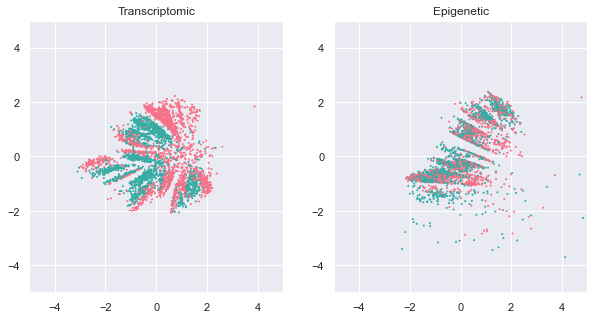

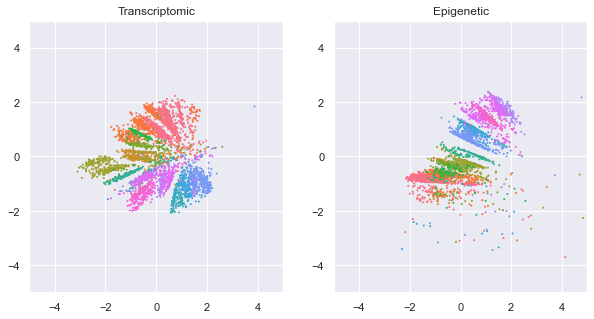

In [4]:
result_dir = paths['package_dir'] / 'data/results/TE'
file = 'Aug27_aT_1-0_aE_10-0_csTE_0-0_ad_0_ld_2_bs_500_ne_5000_ri_0_exit-summary.mat'
out = sio.loadmat(result_dir / file, squeeze_me=True)

plot_representations(out=out,
                     col=discrete_to_color(M['Individual Label'].values),
                     lims=(-5, 5))
plot_representations(out=out,
                     col=discrete_to_color(M['ClusterAnno'].values),
                     lims=(-5, 5))


## Coupled representations indicates outliers. 

 - Representation has ~50 outliers in these representations that form a separate island. 
 - These outliers appear as seaprated points in the uncoupled epigenetic representation.
 - This suggests that E data for these samples has some peculiarities

In [5]:
result_dir = paths['package_dir'] / 'data/results/TE'
file = 'Aug27_aT_1-0_aE_10-0_csTE_10-0_ad_1_ld_2_bs_500_ne_5000_ri_0_exit-summary.mat'
out = sio.loadmat(result_dir / file, squeeze_me=True)

train_label = np.empty((out['zT'].shape[0],),dtype=object)
train_label[out['train_ind']]='train'
train_label[out['val_ind']]='val'

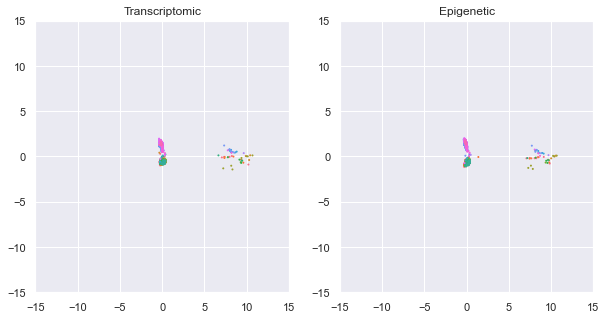

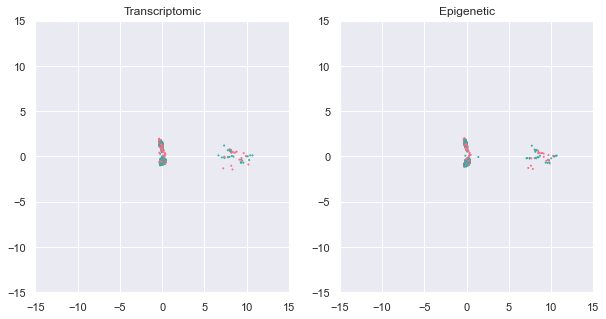

In [6]:
plot_representations(out=out,col=discrete_to_color(M['ClusterAnno'].values),lims=(-15,15))
plot_representations(out=out,col=discrete_to_color(M['Individual Label'].values),lims=(-15,15))

In [7]:
outlier_ind = np.flatnonzero(out['zT'][:,0]>5)
outlier_ind_df = pd.DataFrame({'ind':outlier_ind})
outlier_ind_df.to_csv(paths['package_dir'] / 'data/results/TE/outliers.csv',index=False)
print(f'{outlier_ind.shape[0]} outliers')

44 outliers


(5.0, 6.0)

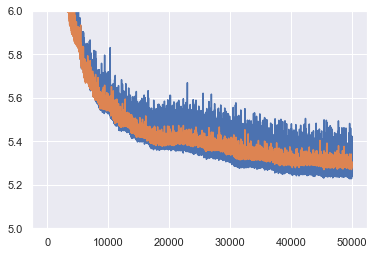

In [8]:
# 50k epoch validation loss is still going down. 
R = pd.read_csv(result_dir / 'logs/Aug27_aT_1-0_aE_10-0_csTE_10-0_ad_1_ld_2_bs_500_ne_50000_ri_1.csv')
plt.plot(R['train_recon_T'])
plt.plot(R['val_recon_T'])
ax = plt.gca()
ax.set_ylim(5,6)

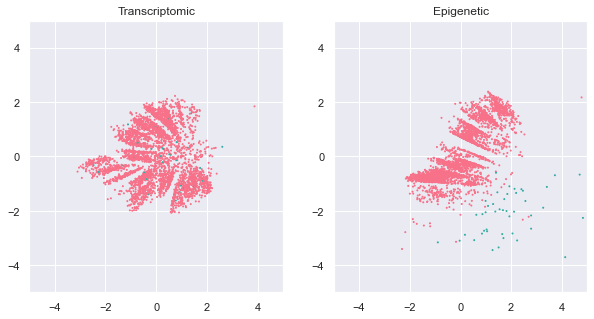

In [9]:
# Outliers appear distinctly in the uncoupled E representation. 
result_dir = paths['package_dir'] / 'data/results/TE'
file = 'Aug27_aT_1-0_aE_10-0_csTE_0-0_ad_0_ld_2_bs_500_ne_5000_ri_0_exit-summary.mat'
out = sio.loadmat(result_dir / file, squeeze_me=True)

outlier_label = np.empty((out['zT'].shape[0],),dtype=object)
outlier_label[outlier_ind] = 'outlier'
outlier_label[~np.isin(np.arange(outlier_label.size),outlier_ind)] = 'inlier'

plot_representations(out=out,col=discrete_to_color(outlier_label),lims=(-5,5))

## Training coupled autoencoders after leaving out previously identified ouliers

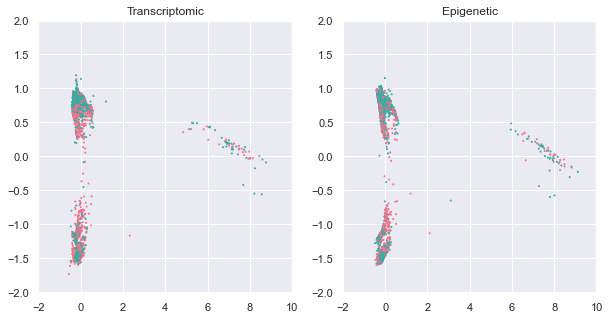

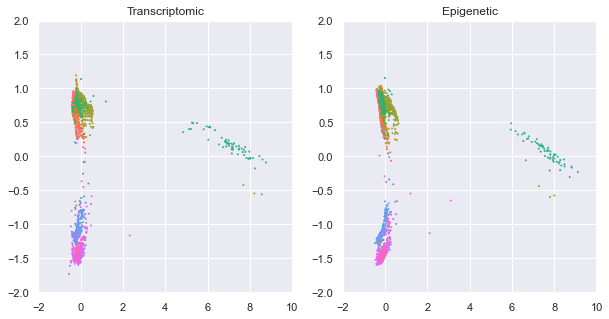

In [10]:
result_dir = paths['package_dir'] / 'data/results/TE_inliers/'
file = 'Aug28_aT_1-0_aE_10-0_csTE_10-0_ad_1_ld_2_bs_500_ne_5000_out_1_ri_0_exit-summary.mat'
out = sio.loadmat(result_dir / file, squeeze_me=True)

outliers_df = pd.read_csv(paths['data_dir'] / 'outliers.csv')
inliers = np.setdiff1d(np.arange(0, out['zT'].shape[0]),
                       outliers_df['ind'].values)


plot_representations(out=out,
                     ind=inliers,
                     col=discrete_to_color(M['Individual Label'].values), 
                     xlim=(-2, 10), ylim=(-2, 2))

plot_representations(out=out,
                     ind=inliers,
                     col=discrete_to_color(M['ClusterAnno'].values), 
                     xlim=(-2, 10), ylim=(-2, 2))


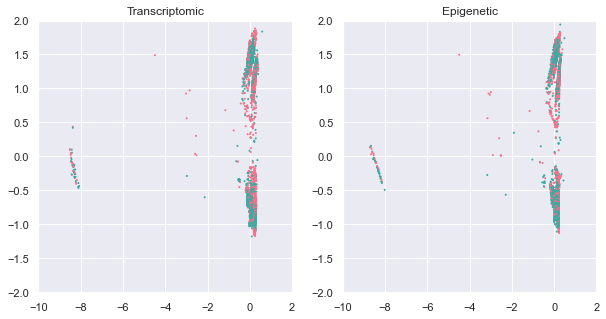

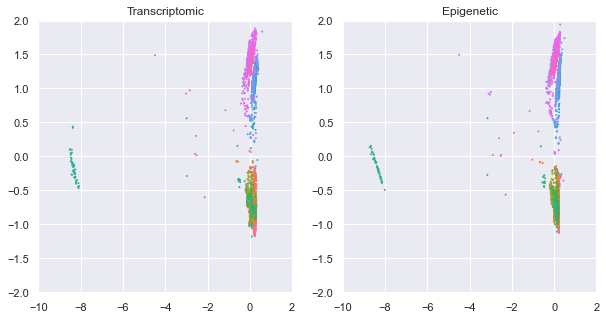

In [11]:
## The same model trained for longer (50k epochs)
file = 'Aug28_aT_1-0_aE_10-0_csTE_10-0_ad_1_ld_2_bs_500_ne_50000_out_1_ri_0_exit-summary.mat'
out = sio.loadmat(result_dir / file, squeeze_me=True)

outliers_df = pd.read_csv(paths['data_dir'] / 'outliers.csv')
inliers = np.setdiff1d(np.arange(0, out['zT'].shape[0]),
                       outliers_df['ind'].values)

plot_representations(out=out,
                     ind=inliers,
                     col=discrete_to_color(M['Individual Label'].values), 
                     xlim=(-10, 2), ylim=(-2, 2))


plot_representations(out=out,
                     ind=inliers,
                     col=discrete_to_color(M['ClusterAnno'].values), 
                     xlim=(-10, 2), ylim=(-2, 2))